# Dependency
Install the shap module.

In [1]:
!pip install shap
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1RBAjHt-iO1LFAYQMbwfxE6hDw-VdljHE' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1RBAjHt-iO1LFAYQMbwfxE6hDw-VdljHE" -O train.json && rm -rf /tmp/cookies.txt

import json
import shap
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from textblob import TextBlob
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from tqdm.notebook import tqdm
tqdm.pandas()
import pdb

--2021-06-18 04:02:08--  https://docs.google.com/uc?export=download&confirm=&id=1RBAjHt-iO1LFAYQMbwfxE6hDw-VdljHE
Resolving docs.google.com (docs.google.com)... 142.250.81.206, 2607:f8b0:4004:82f::200e
Connecting to docs.google.com (docs.google.com)|142.250.81.206|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-38-docs.googleusercontent.com/docs/securesc/v9r21mt9oinvtd9snbbmc4guokj540ds/tos5tqqg9e0h11m068bs9u286q1f696l/1623988875000/15980433337136259916/08238807450680158691Z/1RBAjHt-iO1LFAYQMbwfxE6hDw-VdljHE?e=download [following]
--2021-06-18 04:02:09--  https://doc-08-38-docs.googleusercontent.com/docs/securesc/v9r21mt9oinvtd9snbbmc4guokj540ds/tos5tqqg9e0h11m068bs9u286q1f696l/1623988875000/15980433337136259916/08238807450680158691Z/1RBAjHt-iO1LFAYQMbwfxE6hDw-VdljHE?e=download
Resolving doc-08-38-docs.googleusercontent.com (doc-08-38-docs.googleusercontent.com)... 142.250.73.193, 2607:f8b0:4004:829::2001
Connecting to doc-08-38

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version


# Feature Engineering

In [2]:
# Sample 1000 data from the training set
with open('train.json') as json_file:
    data = json.load(json_file)
df = pd.DataFrame.from_records(data).sample(n=1000, random_state=0)

# Create features from text and reply
def _preprocess(data):

  # Length
  data['text_word_count'] = len(data['text'].split())

  # Polarity and subjectivity
  textblob = TextBlob(data['text'])
  data['text_pol'] = textblob.sentiment.polarity
  data['text_sub'] = textblob.sentiment.subjectivity

  # POS count
  pos_dict = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
  } 
  def _pos_count(text, type):
    count = 0
    for (word, pos) in TextBlob(text).tags:
      if pos in pos_dict[type]:
        count += 1
    return count
  data['text_adj_count'] = _pos_count(data['text'], 'adj')
  data['reply_adj_count'] = _pos_count(data['reply'], 'adj')
  # data['text_adv_count'] = _pos_count(data['text'], 'adv')
  # data['reply_adv_count'] = _pos_count(data['reply'], 'adv')

  # [TODO 1] Create at least 5 features. ###########
  # E.g. Length of reply, sentiment polarity, ...
  #feature 1 
  textreplyblob = TextBlob(data['text']+data['reply'])
  data['textreply_pol'] = textreplyblob.sentiment.polarity
  data['textreply_sub'] = textreplyblob.sentiment.subjectivity


  #feature 2 
  data['categories_word_count'] = len(data['categories'])

  # #feature 3
  data['text_n_count'] = _pos_count(data['text'], 'noun')
  data['reply_n_count'] = _pos_count(data['reply'], 'noun')
 
  # #feature 4
  data['text_verb_count'] = _pos_count(data['text'], 'verb')
  data['reply_verb_count'] = _pos_count(data['reply'], 'verb')

  #feature 5
  sentence = data['text']+data['reply']
  data['tag_count'] = sentence.count('@')

  
  ##################################################

  data['label'] = 1 if data['label']=='real' else 0
  return data

df = df.progress_apply(lambda x: _preprocess(x), axis=1)

# Take labels and remove unused columns in data
labels = df['label'].to_numpy()
df = df.drop(columns=['idx', 'text', 'categories', 'context_idx', 'reply', 'mp4', 'label'])

# Split the dataset for training and validation
X_train,X_test,Y_train,Y_test = train_test_split(*(df, labels), test_size=0.2, random_state=0)

# Model Leanring


## For SVM 

In [3]:
# Train a SVM classifier
svm = sklearn.svm.SVC(kernel='rbf', probability=True)
svm.fit(X_train, Y_train)
print(f"SVC Test Accuracy: {accuracy_score(Y_test, svm.predict(X_test))}")
print(f"SVC Test Loss: {log_loss(Y_test, svm.predict_proba(X_test))}")

SVC Test Accuracy: 0.97
SVC Test Loss: 0.1065780664196501


## For Random Forest

In [4]:
# Train a Random Forest classifier
rfc = sklearn.ensemble.RandomForestClassifier(max_depth=2, random_state=0)
rfc.fit(X_train, Y_train)
print(f"Random Forest Test Accuracy: {accuracy_score(Y_test, rfc.predict(X_test))}")
print(f"Random Forest Test Loss: {log_loss(Y_test, rfc.predict_proba(X_test))}")

Random Forest Test Accuracy: 0.995
Random Forest Test Loss: 0.08596269247552815


## For XGBoost

In [5]:
import xgboost

# Train a XGBoost classifier
xgb = xgboost.XGBClassifier(objective='binary:logistic', n_estimators=2)
xgb.fit(X_train, Y_train)
print(f"XGB Test Accuracy: {accuracy_score(Y_test, xgb.predict(X_test))}")
print(f"XGB Test Loss: {log_loss(Y_test, xgb.predict_proba(X_test))}")

XGB Test Accuracy: 0.99
XGB Test Loss: 0.5286429172754288


# Explaination

## For SVC

In [6]:
##### For SVC #####

# Use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(svm.predict_proba, shap.kmeans(X_train, 100)) # apply k-means first to acclerate (but loss some accuracy)
shap_values = explainer.shap_values(X_test, nsamples=100)

In [7]:
# Plot the SHAP values of the first instance by force plot
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:])

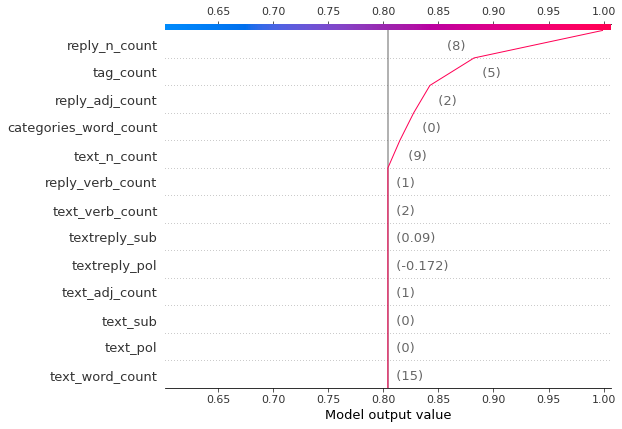

In [8]:
# Plot the SHAP values of the first instance by decision plot
shap.initjs()
shap.decision_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:])

## For Random Forest

In [9]:
##### For RFC #####

# Use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(rfc.predict_proba, shap.kmeans(X_train, 100)) # apply k-means first to acclerate (but loss some accuracy)
shap_values = explainer.shap_values(X_test, nsamples=100)


In [10]:
# Plot the SHAP values of the first instance by force plot
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:]) #, link="logit")

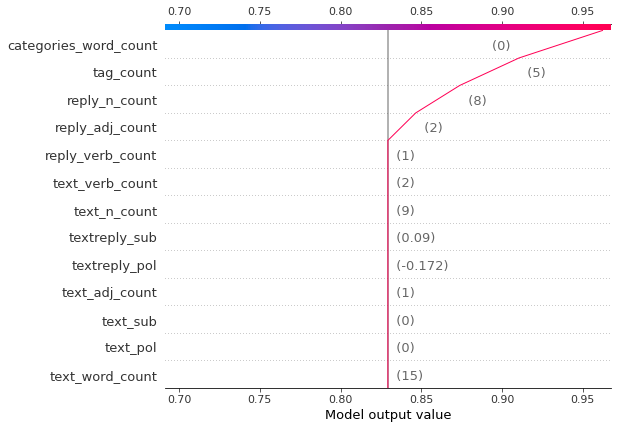

In [11]:
# Plot the SHAP values of the first instance by decision plot
shap.initjs()
shap.decision_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:])

## For XGBoost

In [12]:
##### For XGBootst #####

# Use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(lambda x: xgb.predict_proba(x, validate_features=False), shap.kmeans(X_train, 100))  # apply k-means first to acclerate (but loss some accuracy)
shap_values = explainer.shap_values(X_test, nsamples=100)

In [13]:
# Plot the SHAP values of the first instance by force plot
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:])

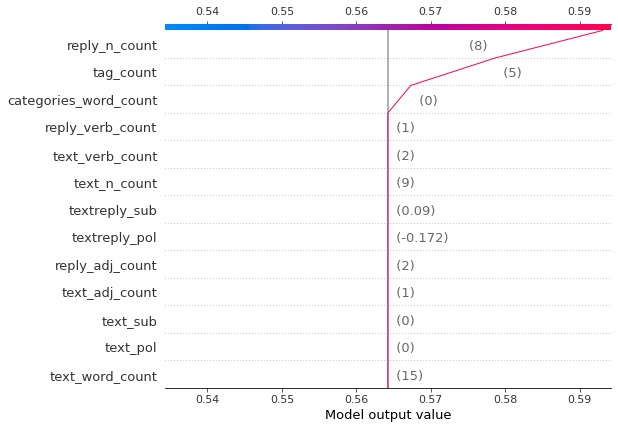

In [14]:
# Plot the SHAP values of the first instance by decision plot
shap.initjs()
shap.decision_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:])

In [15]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

# [TODO 2] Discussion

1. Compare the importance of different features. Are the results similar among different models? Please address what you find below.


No,the same feature do not contribute same shap value among different model.Even in the same model,we can get distinct result on every time. For example,we can found the feature "text_word_count" contribute a little in svc,but it work siginificantly in Random ForestWrite


2. What’ll happen if we remove useless features according to the explanation results? Please do a simple experiment and address what you find.

According to the presentation last 2 week,i assume the influence of categories_number is larger than that of the text_adv_count.

After observating,i found that if we remove useless feature such as number of adv,the influence of main feature will be amplified

3. Without any constraint, please share one additional observation you find.

TA said that the order of feature would't affect the result.But I found that there would a little discrepancy in force_plot if we change order of features 


I observe that if the features are similar,they will influenced by the order,vice versa.The property is also discussed in github issue(https://github.com/dmlc/xgboost/issues/1256) 